In [1]:
! pip install --upgrade diffusers transformers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline, AutoencoderKL, UNet2DConditionModel, DDIMScheduler, DDIMInverseScheduler

In [3]:
model_id = 'stabilityai/stable-diffusion-2-1'
image_size = 768
device = 'cuda'

In [4]:
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")

vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device) 

pipe = StableDiffusionPipeline.from_pretrained(model_id)
# scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
scheduler = DDIMScheduler.from_config(model_id, subfolder="scheduler")
inverse_scheduler = DDIMInverseScheduler.from_config(pipe.scheduler.config)
scheduler.prediction_type = 'epsilon'
inverse


# inverse_scheduler = DDIMInverseScheduler.from_pretrained(model_id, subfolder="scheduler")


/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:215: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
The config attributes {'skip_prk_steps': True} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [5]:
prompt = ["a photograph of an astronaut riding a horse"]
empty_prompt = [""]
prompt = empty_prompt

height = 768                        # default height of Stable Diffusion
width = 768                         # default width of Stable Diffusion

num_inference_steps = 32           # Number of denoising steps

guidance_scale = 9                # Scale for classifier-free guidance

generator = torch.manual_seed(1)    # Seed generator to create the inital latent noise

batch_size = len(prompt)


In [6]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

text_embeddings = text_encoder(text_input.input_ids.to(device))[0]


In [7]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]


In [8]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])


In [9]:
latents = torch.randn(
    (batch_size, unet.in_channels, 64, 64),
    generator=generator,
)
latents = latents.to(device)


<ipython-input-9-6f650c1412d2>:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, 64, 64),


In [10]:
scheduler.set_timesteps(num_inference_steps)

In [11]:
latents = latents * scheduler.init_noise_sigma

In [12]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample


  0%|          | 0/32 [00:00<?, ?it/s]

In [13]:
# scale and decode the image latents with vae
decode_latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(decode_latents).sample

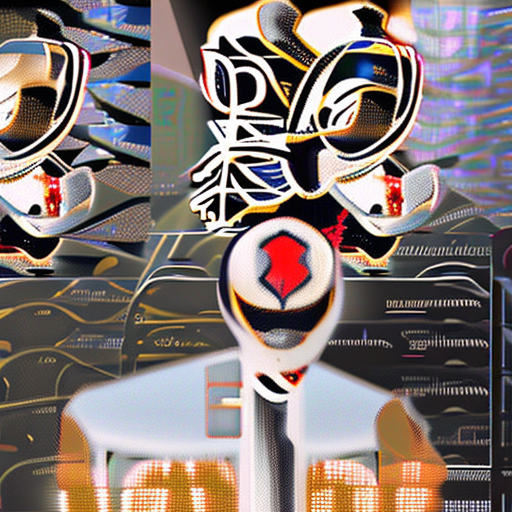

In [14]:
from PIL import Image

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]


Now we try to invert an image with DDIMInverse. First take an image and reencode it into the latent space.

In [15]:
inverse_scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = inverse_scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = inverse_scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/32 [00:00<?, ?it/s]

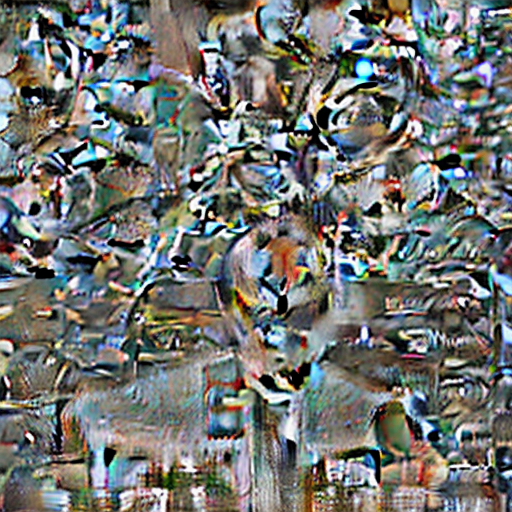

In [16]:
# scale and decode the image latents with vae
decode_latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(decode_latents).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

Regenerate the image

In [17]:
for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/32 [00:00<?, ?it/s]

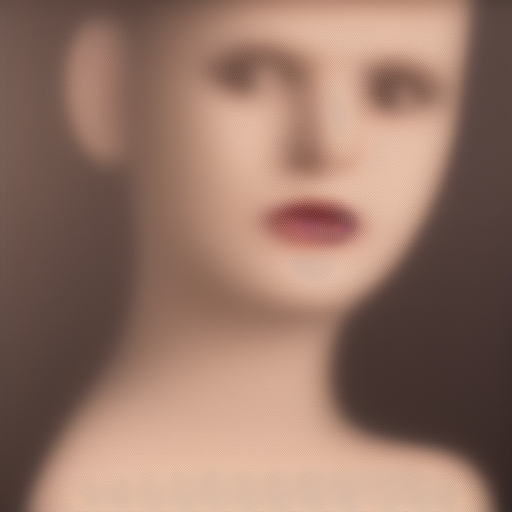

In [18]:
decode_latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(decode_latents).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [19]:
inverse_scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('clip_sample', False),
            ('set_alpha_to_zero', True),
            ('steps_offset', 1),
            ('prediction_type', 'v_prediction'),
            ('clip_sample_range', 1.0),
            ('set_alpha_to_one', False),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('sample_max_value', 1.0),
            ('_class_name', 'DDIMScheduler'),
            ('_diffusers_version', '0.8.0'),
            ('skip_prk_steps', True)])

In [5]:
from diffusers import StableDiffusionPipeline, DDIMInverseScheduler
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1")
invscheduler = DDIMInverseScheduler.from_config(pipe.scheduler.config)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
The config attributes {'skip_prk_steps': True} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [6]:
invscheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('clip_sample', False),
            ('set_alpha_to_zero', True),
            ('steps_offset', 1),
            ('prediction_type', 'v_prediction'),
            ('clip_sample_range', 1.0),
            ('set_alpha_to_one', False),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('sample_max_value', 1.0),
            ('_class_name', 'DDIMScheduler'),
            ('_diffusers_version', '0.8.0'),
            ('skip_prk_steps', True)])